## Preprocessing

In [2]:
import os
import numpy as np
from nilearn import image
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
ROIs = ['V1','fusiform','IT','LOC', 'occitemp']

In [4]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02/'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

# issue with 1201161
sub_dirs = [s for s in sub_dirs if s != '1201161_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
32 subjects


In [5]:
# Analysis helper functions
def get_mask_array(mask_path):
    # loads mask applied to nifty (.nii.gz) file
    # mask selects voxels to be included/discarded
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels

def load_roi_mask_combined(subj,run_num,roi):
    if run_num in [1,2]:
        phase_num = '12' 
    elif run_num in [3,4]:
        phase_num = '34'
    elif run_num in [5,6]:
        phase_num = '56'
    mask_path = proj_dir + '/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_' + phase_num + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

# Univariate Time Course Plot

Preprocessing...

In [123]:
# for each subject and each run
runA = np.zeros(9)
runB = np.zeros(9)
V1 = np.zeros(9)
fusiform = np.zeros(9)
IT = np.zeros(9)
LOC = np.zeros(9)
occitemp = np.zeros(9)
wholebrain = np.zeros(9)

for subject in sub_dirs:
    print(subject)
    for run in [1, 2]:
        
        # load subject's time series for this run
        timeseries = image.load_img(proj_dir + subject + '/analysis/firstlevel/preproc_recognition_run_' +
                                             str(run) + '.feat/filtered_func_data.nii.gz')
        timeseries = stats.zscore(timeseries.get_data().transpose((3, 0, 1, 2)), axis=0)
        
        # use information in regressor/run_x folder to make hasImage vector
        hasImage = [0]*240
        for cope in ['bed', 'bench', 'chair', 'table']:
            with open('/home/jgunn/neurosketch/timepoints/' + subject[:7] + '_' + str(run) + '_' + cope + '.txt') as f:
                times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                for t in times:
                    tr = float(t)/1.5
                    hasImage[int(tr)] = 1
        
        # for all 80 volumes where hasImage = 1, take 4 +/- adjacent indicies in corresponding volume set
        # apply the ROI masks to them, 
        # then vstack output of full loop
        # result being 80 x k x 9 matrix where k is number of voxels in roi_mask
        for roi in ['occitemp']: # select k voxels
            print(roi)
            roi_mask = load_roi_mask_combined(subject, 1, roi) if roi != 'wholebrain' else None
            results = (np.zeros((80, 9, int(np.sum(roi_mask)))) if roi != 'wholebrain' else
                       np.zeros((80, 9, timeseries[0].size))) # 80 x 9 x k
            counter = 0
            
            for i, has in enumerate(hasImage): # 80 times
                if has and i > 3 and i < 236:
                    start = i-4
                    end = i+5

                    result = timeseries[start][roi_mask==1] if roi != 'wholebrain' else timeseries[start].flatten()
                    for i in range(start+1, end): # 9 times
                        if roi == 'wholebrain':
                            result = np.vstack((result, timeseries[i].flatten()))
                        else:
                            result = np.vstack((result, timeseries[i][roi_mask==1])) # 9 x k
                    results[counter] = result
                    counter += 1
            
            results = np.mean(results, axis = 0)
            results = np.mean(results, axis = 1)
            if roi == 'V1':
                V1 = np.vstack((V1, results))
            elif roi == 'fusiform':
                fusiform = np.vstack((fusiform, results))
            elif roi == 'IT':
                IT = np.vstack((IT, results))
            elif roi == 'LOC':
                LOC = np.vstack((LOC, results))
            elif roi == 'occitemp':
                occitemp = np.vstack((occitemp, results))
            else:
                wholebrain = np.vstack((wholebrain, results))
                if run == 1:
                    runA = np.vstack((runA, results))
                else:
                    runB = np.vstack((runB, results))
                    
runA = np.delete(runA, (0), axis=0)
runB = np.delete(runB, (0), axis=0)
V1 = np.delete(V1, (0), axis=0)
fusiform = np.delete(fusiform, (0), axis=0)
IT = np.delete(IT, (0), axis=0)
LOC = np.delete(LOC, (0), axis=0)
occitemp = np.delete(occitemp, (0), axis=0)
wholebrain = np.delete(wholebrain, (0), axis=0)

0110171_neurosketch


/home/jgunn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


occitemp
occitemp


KeyboardInterrupt: 

Now just modify what "everyone" refers to to indicate which group to graph

(64, 9)


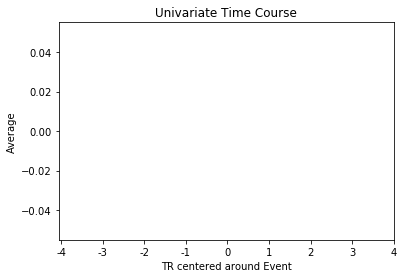

In [113]:
everyone = occitemp
print(np.shape(everyone))

x = np.arange(0, 9)
y = np.mean(everyone, axis=0)
e = np.std(everyone, axis=0)
plt.errorbar(x, y)
plt.title('Univariate Time Course')
plt.xlabel('TR centered around Event')
plt.ylabel('Average')
plt.xticks(np.arange(0, 9), ['-4', '-3', '-2', '-1', '0', '1', '2', '3', '4'])
plt.show()

**Conclusion**: Peak of response is at 3 seconds after display.

## Vanilla Classification Performance

Sanity check. How does classifer perform simply classifying whether an image has just occurred or not?

In [25]:
# train on run 1, test on run 2 using SVM or 4-way softmax (logistic regression classifier)
# how to define training set?
# get the 80 cope maps for run 1 per subject
# i'll do it for the whole brain and then with ROI masks applied, compare results

# this time, we only pick one instead of (presumably at +3, maybe +2) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

predicted = []
actual = []

for subject in sub_dirs:
    print(subject)
    trainingX = []
    trainingY = []
    testX = []
    testY = []
    roi_mask = load_roi_mask_combined(subject, 1, 'occitemp')
    for run in [1, 2]:
        
        # load subject's time series for this run
        timeseries = image.load_img(proj_dir + subject + '/analysis/firstlevel/preproc_recognition_run_' +
                                             str(run) + '.feat/filtered_func_data.nii.gz')
        timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
        timeseries = stats.zscore(timeseries, axis=0)
        timeseries[np.isnan(timeseries)] = 0

        # use information in regressor/run_x folder to make hasImage vector
        hasImage = [0]*240
        for cope in ['bed', 'bench', 'chair', 'table']:
            with open('/home/jgunn/neurosketch/timepoints/' + subject[:7] + '_' + str(run) + '_' + cope + '.txt') as f:
                times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                for t in times:
                    tr = float(t)/1.5
                    hasImage[int(tr)] = 1
        
        # wherever hasImage, get associated volume and flatten it for training
        for i, has in enumerate(hasImage): # 80 times
            if i + 3 < 240:
                if run == 1:
                    trainingX.append(timeseries[i+3][roi_mask==1])
                    trainingY.append(has)
                else:
                    testX.append(timeseries[i+3][roi_mask==1])
                    testY.append(has)
                    
    lin_clf = LogisticRegression()
    lin_clf.fit(trainingX, trainingY)
    predicted = predicted + lin_clf.predict(testX).tolist()
    actual = actual + testY
    
print(np.mean(np.equal(actual, predicted)))

0110171_neurosketch


/home/jgunn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch


In [26]:
np.mean(np.equal(predicted, actual))

0.65994198312236285

In [30]:
# train on run 1, test on run 2 using SVM or 4-way softmax (logistic regression classifier)
# how to define training set?
# get the 80 cope maps for run 1 per subject
# i'll do it for the whole brain and then with ROI masks applied, compare results

# this time, we only pick one instead of (presumably at +3, maybe +2) 

from sklearn.linear_model import LogisticRegression

predicted = []
actual = []

for subject in sub_dirs:
    print(subject)
    trainingX = []
    trainingY = []
    testX = []
    testY = []
    roi_mask = load_roi_mask_combined(subject, 1, 'occitemp')
    for run in [1, 2]:

        # load subject's time series for this run
        timeseries = image.load_img(proj_dir + subject + '/analysis/firstlevel/preproc_recognition_run_' +
                                             str(run) + '.feat/filtered_func_data.nii.gz')
        timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
        timeseries = stats.zscore(timeseries, axis=0)
        timeseries[np.isnan(timeseries)] = 0
        
        # use information in regressor/run_x folder to make hasImage vector
        hasImage = [0]*240
        for cope in ['bed', 'bench', 'chair', 'table']:
            with open('/home/jgunn/neurosketch/timepoints/' + subject[:7] + '_' + str(run) + '_' + cope + '.txt') as f:
                times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                for t in times:
                    tr = float(t)/1.5
                    if cope == 'bed':
                        hasImage[int(tr)] = 1
                    elif cope == 'bench':
                        hasImage[int(tr)] = 2
                    elif cope == 'chair':
                        hasImage[int(tr)] = 3
                    elif cope == 'table':
                        hasImage[int(tr)] = 4
        
        # wherever hasImage, get associated volume and flatten it for training
        for i, has in enumerate(hasImage): # 80 times
            if has > 0:
                if run == 1:
                    trainingX.append(timeseries[i+3][roi_mask==1])
                    trainingY.append(has-1)
                else:
                    testX.append(timeseries[i+3][roi_mask==1])
                    testY.append(has-1)
                    
    lin_clf = LogisticRegression()
    lin_clf.fit(trainingX, trainingY)
    predicted = predicted + lin_clf.predict(testX).tolist()
    actual = actual + testY
    #scores = scores + cross_val_score(lin_clf, trainingX + testX, trainingY +testY).tolist()
    
print(np.mean(np.equal(actual, predicted)))

0110171_neurosketch


/home/jgunn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
0.33125


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

scores = []

for subject in sub_dirs[:1]:
    print(subject)
    trainingX = []
    trainingY = []
    testX = []
    testY = []
    roi_mask = load_roi_mask_combined(subject, 1, 'occitemp')
    print(np.sum(roi_mask))
    for run in [1, 2]:

        # load subject's time series for this run
        timeseries = image.load_img(proj_dir + subject + '/analysis/firstlevel/preproc_recognition_run_' +
                                             str(run) + '.feat/filtered_func_data.nii.gz')
        timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
        timeseries = stats.zscore(timeseries, axis=0)
        timeseries[np.isnan(timeseries)] = 0
        
        # use information in regressor/run_x folder to make hasImage vector
        hasImage = [0]*240
        for cope in ['bed', 'bench', 'chair', 'table']:
            with open('/home/jgunn/neurosketch/timepoints/' + subject[:7] + '_' + str(run) + '_' + cope + '.txt') as f:
                times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                for t in times:
                    tr = float(t)/1.5
                    if cope == 'bed':
                        hasImage[int(tr)] = 1
                    elif cope == 'bench':
                        hasImage[int(tr)] = 2
                    elif cope == 'chair':
                        hasImage[int(tr)] = 3
                    elif cope == 'table':
                        hasImage[int(tr)] = 4
        
        # wherever hasImage, get associated volume and flatten it for training
        for i, has in enumerate(hasImage): # 80 times
            if has > 0:
                if run == 1:
                    trainingX.append(timeseries[i+3][roi_mask==1])
                    trainingY.append(has-1)
                else:
                    testX.append(timeseries[i+3][roi_mask==1])
                    testY.append(has-1)
                    
    lin_clf = LogisticRegression()
    rfecv = RFECV(estimator=lin_clf, step=.01, scoring='accuracy')
    rfecv.fit(trainingX + testX, trainingY + testY)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    #lin_clf.fit(trainingX, trainingY)
    #predicted = predicted + lin_clf.predict(testX).tolist()
    #actual = actual + testY
    #scores = scores + cross_val_score(lin_clf, trainingX + testX, trainingY +testY).tolist()
    
#print(np.mean(np.equal(actual, predicted)))
#np.mean(scores)

0110171_neurosketch
10730.0


/home/jgunn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Optimal number of features : 4845


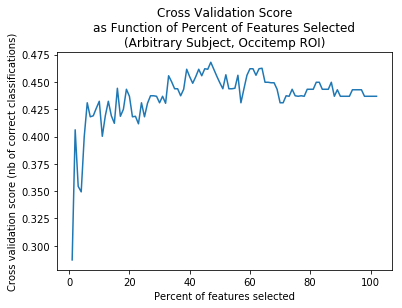

In [29]:
plt.figure()
plt.title('Cross Validation Score\nas Function of Percent of Features Selected\n(Arbitrary Subject, Occitemp ROI)')
plt.xlabel("Percent of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [96]:
np.shape(timeseries[0][roi_mask==1][rfecv.support_])

(170,)

In [14]:
from sklearn import svm

from sklearn.feature_selection import RFE
estimator = svm.LinearSVC()
selector = RFE(estimator, .25*N, step=1)



LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [15]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(trainingX, trainingY)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

KeyboardInterrupt: 

## Follow-up by doing RFE based on the smallest weights, using paper that Norman recommended long ago.
## Visualize slices that expose regions that prior work has identified as object selective
## Apply searchlight with larger radius, re-do analyses